In [33]:
import creds
import matplotlib.pyplot as plt
from cointegration.funcs import * 
import datetime as dt
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.optimize as spo

tok = creds.token_ro_all

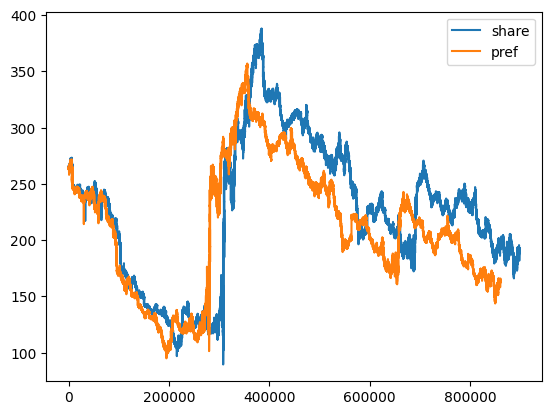

In [34]:
ticker = 'SBER'
share = pd.read_csv(f'../data/shares_data/companies/{ticker}.csv')
pref = pd.read_csv(f'../data/shares_data/companies_pref/{ticker}P.csv')

plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
plt.legend()

##### Matching

Time Series1:  4.5% is missing (899121 ==> 859080)
Time Series2:  0.2% is missing (860938 ==> 859080)


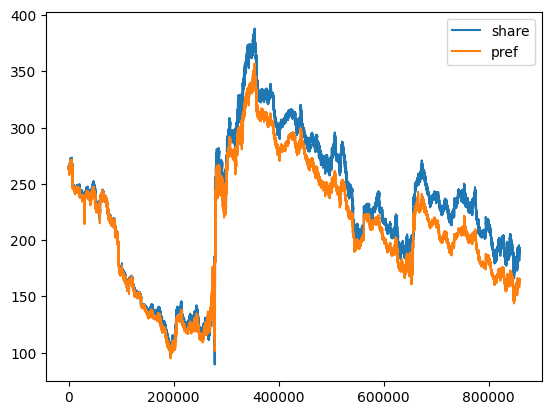

In [35]:
share, pref = match_ts(share, pref)

plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
plt.legend()

##### Removing linear trend from sample data and making STD bands

[2.57342573 0.13951242]


(-5.0, 17.0)

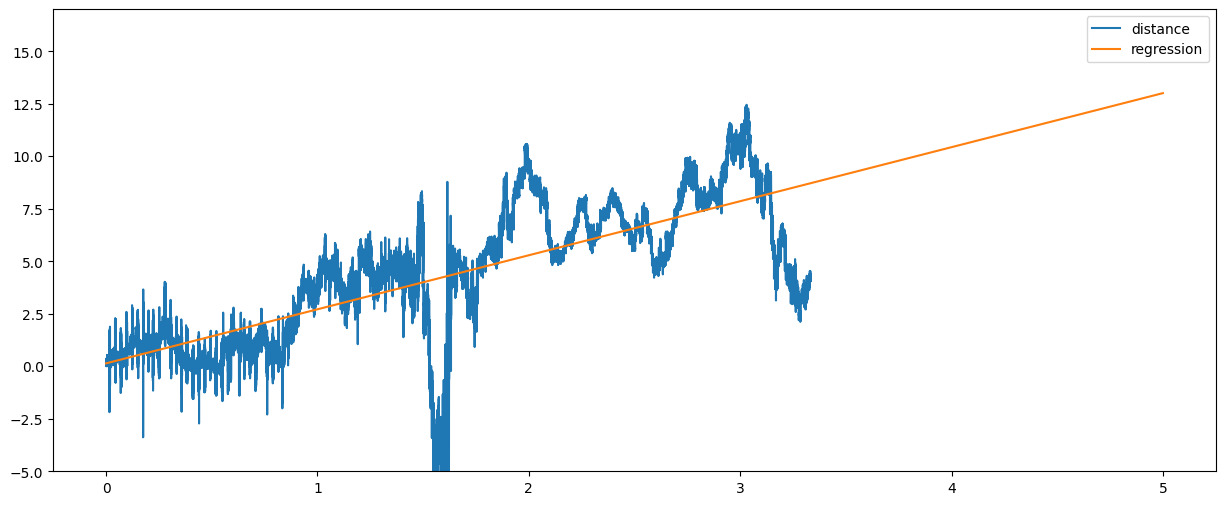

In [48]:
dist = 100*(share['close'] - pref['close']) / share['close']
cut = int(2*len(dist)/3)
dist_check = dist[cut:]

dist = dist[:cut]

dist_df = pd.DataFrame()
dist_df['dist'] = dist
dist_df['time'] = np.linspace(0, 5*2/3, cut)

coefs = np.polyfit(dist_df['time'], dist_df['dist'], 1)
print(coefs)
lin = np.poly1d(coefs)
x_ax = np.linspace(0, 5, 100)

plt.figure(figsize=(15, 6))
plt.plot(dist_df['time'], dist_df['dist'], label='distance')
plt.plot(x_ax, lin(x_ax), label='regression')
plt.plot()
plt.legend()
plt.ylim(-5, 17)

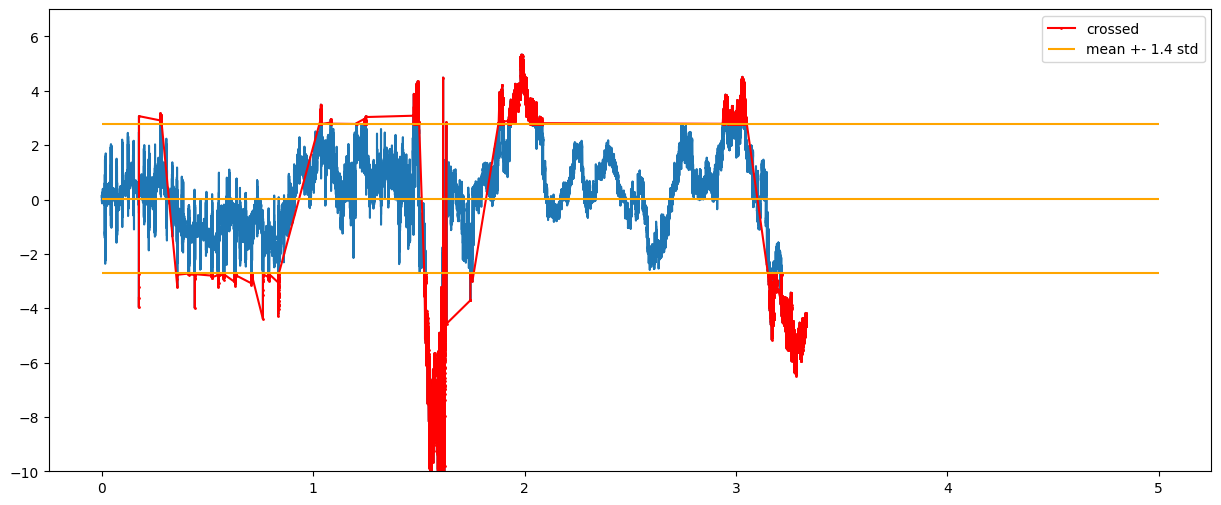

In [49]:
dist_df['demeaned'] = dist_df['dist'] - lin(dist_df['time'])
clipped = dist_df.clip(dist_df['demeaned'].quantile(0.02), dist_df['demeaned'].quantile(0.98), axis=1)
mean = clipped['demeaned'].mean()
std = clipped['demeaned'].std()
mul = 1.4
cross = dist_df.loc[(dist_df['demeaned'] > mean+std*mul) | (dist_df['demeaned'] < mean-std*mul)]

plt.figure(figsize=(15, 6))
plt.plot(dist_df['time'], dist_df['demeaned'])
plt.plot(cross['time'], cross['demeaned'], label='crossed', color='red', marker='o',markersize=1)
plt.hlines([mean, mean-std*mul, mean+std*mul], 0, 5, label=f'mean +- {mul} std', colors='orange')
plt.plot()
plt.legend()
plt.ylim(-10, 7)
plt.show()

##### Checking out of sample data with params from sample

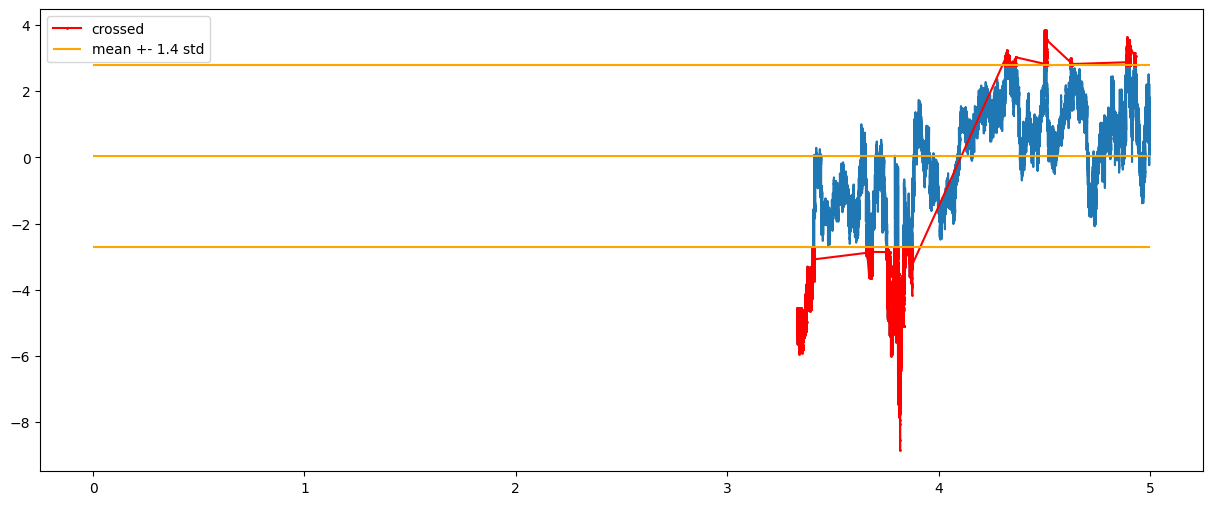

In [47]:
check_df = pd.DataFrame()
check_df['dist'] = dist_check
check_df['time'] = np.linspace(5*2/3, 5, len(dist_check))
check_df['demeaned'] = check_df['dist'] - lin(check_df['time'])
cross_check = check_df.loc[(check_df['demeaned'] > mean+std*mul) | (check_df['demeaned'] < mean-std*mul)]

plt.figure(figsize=(15, 6))
plt.plot(check_df['time'], check_df['demeaned'])
plt.plot(cross_check['time'], cross_check['demeaned'], label='crossed', color='red', marker='o', markersize=1)
plt.hlines([mean, mean-std*mul, mean+std*mul], 0, 5, label=f'mean +- {mul} std', colors='orange')
plt.plot()
plt.legend()
# plt.ylim(-5, 7)

## Cointegraition testing